*In this article, I try to visualize the last four semesters in my degree as a directed graph with courses as nodes and prerequisite relations as edges. Will my plan work, or am I missing prerequisites? NetworkX and yEd are used for creating and displaying the graph.*

<hr>

# The problem

I want to graduate in at least two years which means I need to pass a certain set of courses in a specific sequence. 

There are a lot of complications:

- Not all courses are available every semester; certain courses can only be taken in the Fall term, others only in the Winter.

- Many courses have prerequisites, often the prerequisites have prerequisites.

- There are electives and a large library of possibilities.



# Definitions

According to uOttawa's [sheet on course enrolment terminology](http://www.uottawa.ca/undergraduate-course-registration/enrolment-forms-and-tools/understanding-course-schedules), the academic year is divided into three "terms":

1. Fall (September to December)
2. Winter (January to April)
3. Spring-Summer (May to August)

Courses are encoded in the following way:

>Each course is designated by a seven-character code made up of three letters and four digits. The three letters stand for the subject. For example, CRM stands for criminology. The first digit is for the year of study (1000-level courses — those that start with 1 — are first year courses)...

# Collecting the data

The University of Ottawa does not make this easy. Course information is spread out over at least three separate databases:

- The [course catalogue](http://catalogue.uottawa.ca/en/courses/). Contains most of the information I want, except for scheduling and availability. No search engine, so I had to look up a [course code page](http://catalogue.uottawa.ca/en/courses/csi/) and `CTRL-F`.

- The [course timetable](https://web30.uottawa.ca/v3/SITS/timetable/Search.aspx). Has a search engine (a clumsy one). Provides schedules for courses in the next two terms. There is no way to know if a course will be held in a term later than the next two, so I have to hope that the pattern doesn't change much (i.e. since SEG 2105 is only held in the Fall term this year, it will only be held in the Fall next year). **Does not provide any prerequisite information!** I feel bad for any one who tries to use this as their sole information source...

- The enrollment system. I can't link to this as it can only be accessed through "uoZone" (uOttawa's internal system). As far as I know, this is the only place where course availability and number of available seats are given. This software is atrocious. Instead of following the universally agreed-upon course code system, courses are assigned a seemingly random sequence of numbers and letters. I have 1000 other complaints, but I'll spare you the rant.

After hours pouring over the [program requirements](http://catalogue.uottawa.ca/en/undergrad/major-computer-science/#programrequirementstext) and the [course catalogue](http://catalogue.uottawa.ca/en/courses/), I had a list of candidates and a possible schedule. But will it work? Have I missed a prerequisite or planned to take a course in the Fall that is only available in the Winter? This stuff is too complicated...I need a visual.

# Importing the data

I created a spreadsheet of all the courses I'm planning on taking and furnished it with various information about them. The most confusing aspect is the prerequisite chain, so I'd like to visualize this as a directed graph with courses as nodes and prerequisite links as edges.

In [1]:
import pandas as pd

In [89]:
df = pd.read_csv('course_schedule.csv')
df

,subject_code,digit_code,course_code,course_name,prerequisites,expected_term,expected_year,required,term_availability
0,CSI,2110,CSI2110,Data Structures and Algorithms,"ITI 1121, MAT 1348",F,2017,True,"F, W"
1,SEG,2105,SEG2105,Introduction to Software Engineering,ITI 1121,F,2017,True,F
2,PSY,4130,PSY4130,History and Systems of Psychology,NaN,F,2017,False,"F, W"
3,MAT,1320,MAT1320,Calculus I,NaN,F,2017,False,"S, F, W"
4,CSI,2101,CSI2101,Discrete Structures,MAT 1348,W,2018,True,W
5,CSI,2911,CSI2911,Professional Practice in Computing,NaN,W,2018,True,W
6,CSI,2132,CSI2132,Databases I,CSI 2110,W,2018,True,W
7,MAT,1322,MAT1322,Calculus II,MAT 1320,W,2018,False,"S, F, W"
8,CSI,2120,CSI2120,Programming Paradigms,CSI 2110,W,2018,True,W
9,CSI,3105,CSI3105,Design and Analysis of Algorithms,"CSI 2110, CSI 2101",F,2018,True,F


# Create list of nodes

Each course_code will be a node in the directed graph.

In [90]:
df.columns

Index(['subject_code', 'digit_code', 'course_code', 'course_name',
       'prerequisites', 'expected_term', 'expected_year', 'required',
       'term_availability'],
      dtype='object')

In [91]:
courses = df['course_code']
courses

0     CSI2110
1     SEG2105
2     PSY4130
3     MAT1320
4     CSI2101
5     CSI2911
6     CSI2132
7     MAT1322
8     CSI2120
9     CSI3105
10    CSI3120
11    SEG3125
12    CSI4130
13    CSI3140
14    CSI3130
Name: course_code, dtype: object

# Create list of edges

Nodes are linked by prerequisite relations. For example, MAT1320 -> MAT1322 (because taking Calculus II requires having already passed Calculus I).

In [92]:
prerequisites = df['prerequisites']
prerequisites

0      ITI 1121, MAT 1348
1                ITI 1121
2                     NaN
3                     NaN
4                MAT 1348
5                     NaN
6                CSI 2110
7                MAT 1320
8                CSI 2110
9     CSI 2110, CSI 2101 
10     CSI 2101, CSI 2120
11               SEG 2105
12     CSI 3105, MAT 1341
13     CSI 2110, CSI 2132
14               CSI 2132
Name: prerequisites, dtype: object

## Weird Unicode thing

I got the prerequisites by copy/pasting from the course catalogue, but some of them have extra characters.

In [121]:
# Copy and pasted straight from my spreadsheet
weird_string = " ITI 1121, MAT 1348"
repr(weird_string)

"'\\xa0ITI\\xa01121,\\xa0MAT\\xa01348'"

These characters are invisible when printed:

In [122]:
print(weird_string)

 ITI 1121, MAT 1348


According to [samwize on StackOverflow](https://stackoverflow.com/a/11566398/6591491), `\xa0` is "actually non-breaking space in Latin1 (ISO 8859-1), also chr(160)". I don't really understand what that means, but I'm guessing `\xa0` is some kind of substitute for a space.

In any case, keeping these characters made for ugly output so I chose to remove them. StackOverflow suggests [`unicodedata.normalize()`](https://docs.python.org/2/library/unicodedata.html#unicodedata.normalize). The documentation is a bit vague on what the different "forms" mean ("NFC", "NFKC", "NFD", and "NFKD") and I don't feel like researching this right now so...TRIAL AND ERROR IT IS!

In [124]:
import unicodedata

In [128]:
unicode_forms = ["NFC", "NFKC", "NFD", "NFKD"]

for form in unicode_forms:
    rep = repr(unicodedata.normalize(form, weird_string))
    print(f"{form}: {rep}")

NFC: '\xa0ITI\xa01121,\xa0MAT\xa01348'
NFKC: ' ITI 1121, MAT 1348'
NFD: '\xa0ITI\xa01121,\xa0MAT\xa01348'
NFKD: ' ITI 1121, MAT 1348'


NFKC and NFKD look good. I'll pick the former for no good reason.

In [129]:
def course_formatter2(course):
    '''(str) -> str
    Takes a course code and removes unicode (\xa0) character as well as commas
    and spaces.'''
    return unicodedata.normalize("NFKC", course).replace(',', '').replace(' ', '')

Why `course_formatter2()`? Because I used `course_formatter()` before looking into the problem more closely, it worked OK.

In [132]:
def course_formatter(course):
    '''(str) -> str
    Takes a course code and removes unicode (\xa0) character as well as commas
    and spaces.'''
    return course.replace(u'\xa0', '').replace(',', '').replace(' ', '')

In [131]:
# list of tuples
edges = []

for i, relation in enumerate(prerequisites):
    # Ignore courses with no prerequisites
    if not pd.isnull(relation):
        rs = relation.split(',')
        tmp = []
        for r in rs:
            tmp.append((courses[i], course_formatter2(r)))
        edges.append(tmp)

edges

[[('CSI2110', 'ITI1121'), ('CSI2110', 'MAT1348')],
 [('SEG2105', 'ITI1121')],
 [('CSI2101', 'MAT1348')],
 [('CSI2132', 'CSI2110')],
 [('MAT1322', 'MAT1320')],
 [('CSI2120', 'CSI2110')],
 [('CSI3105', 'CSI2110'), ('CSI3105', 'CSI2101')],
 [('CSI3120', 'CSI2101'), ('CSI3120', 'CSI2120')],
 [('SEG3125', 'SEG2105')],
 [('CSI4130', 'CSI3105'), ('CSI4130', 'MAT1341')],
 [('CSI3140', 'CSI2110'), ('CSI3140', 'CSI2132')],
 [('CSI3130', 'CSI2132')]]

This is a bit confusing because it looks like CSI2110 -> ITI1121 (when it is the other way around).

In [133]:
# The same, but swapping the order
edges = []

for i, relation in enumerate(prerequisites):
    # Ignore courses with no prerequisites
    if not pd.isnull(relation):
        rs = relation.split(',')
        tmp = []
        for r in rs:
            tmp.append((course_formatter(r), courses[i]))
        edges.append(tmp)

edges

[[('ITI1121', 'CSI2110'), ('MAT1348', 'CSI2110')],
 [('ITI1121', 'SEG2105')],
 [('MAT1348', 'CSI2101')],
 [('CSI2110', 'CSI2132')],
 [('MAT1320', 'MAT1322')],
 [('CSI2110', 'CSI2120')],
 [('CSI2110', 'CSI3105'), ('CSI2101', 'CSI3105')],
 [('CSI2101', 'CSI3120'), ('CSI2120', 'CSI3120')],
 [('SEG2105', 'SEG3125')],
 [('CSI3105', 'CSI4130'), ('MAT1341', 'CSI4130')],
 [('CSI2110', 'CSI3140'), ('CSI2132', 'CSI3140')],
 [('CSI2132', 'CSI3130')]]

# Create DiGraph

With the [NetworkX library](https://networkx.github.io/).

In [134]:
import networkx as nx

In [135]:
G = nx.DiGraph()

## Adding nodes and edges

In [136]:
G.add_nodes_from(courses)

In [137]:
for edge in edges:
    G.add_edges_from(edge)

# Drawing the graph?

> NetworkX provides basic functionality for visualizing graphs, but its main goal is to enable graph analysis rather than perform graph visualization. In the future, graph visualization functionality may be removed from NetworkX or only available as an add-on package. - [Documentation for NetworkX](https://networkx.readthedocs.io/en/stable/reference/drawing.html)

I'm going to try it anyway.

In [100]:
import matplotlib.pyplot as pl

In [101]:
%matplotlib inline

In [110]:
# Hide deprecation warnings
import warnings
warnings.filterwarnings('ignore')

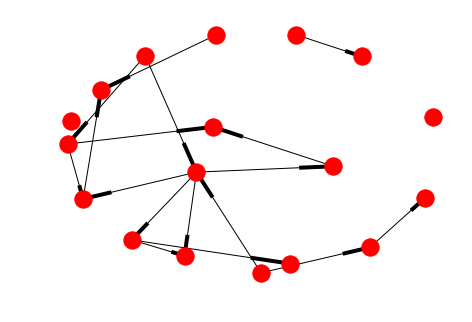

In [111]:
nx.draw(G)

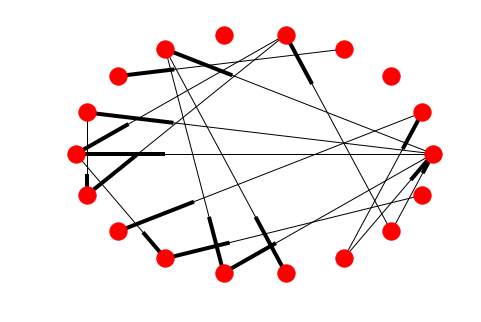

In [112]:
nx.draw_circular(G)

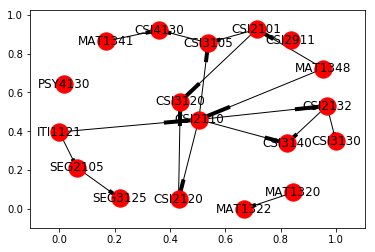

In [104]:
nx.draw_networkx(G)

Kinda cool, but I think yEd might be better for producing a finished graphic.

# Export to GraphML

NetworkX can export to a lot of different formats, but I chose GraphML because yEd also supports it.

In [105]:
nx.write_graphml(G, "course_prerequisites.graphml")

This exported the nodes and edges, but the labels are missing! Google led me to [this blog](https://thirld.com/blog/2012/01/31/making-yed-import-labels-from-graphml-files/) which had some good advice.

In [116]:
# Give nodes labels
for node in G.nodes():
    G.node[node]['label'] = node

In [107]:
# Export again
nx.write_graphml(G, "course_prerequisites.graphml")

The were exported, but yEd still required some tweaking to get them to display. The blog post I linked to earlier explains it (with screenshots!). Here is the critical part:

>"We need to map the "Label" property imported from the GraphML file onto the internal property that yEd uses for labels. To do this, click Edit, Properties Mapper. Click the little plus sign under Configurations, and then 'New Configuration for Nodes.' Now click the plus sign next to 'Mappings'. If you're lucky, yEd should figure out what you're trying to do, and automatically select the right mapping." - [Berzan](https://thirld.com/blog/2012/01/31/making-yed-import-labels-from-graphml-files/)

# Finished graph

Notes:

- I used yEd's "hierarchy" layout.

- Courses I've already taken are color coded green.

- There are four groups, representing the courses I intend to take for a given term.

- A few arrows were repositioned (by hand) to make the group labels easier to read.


<img src="course_prerequisites.png">

## Interpretation

Taking the courses in this order should ensure prerequisites are always satisfied. 

There are a few other interesting takeaways:

- CSI 2110 is a prerequisite for four courses. Failing to acquire it in the Fall of 2017 will severely screw up my schedule.

- PSY 4130 and CSI 2911 are not prerequisites for any course, so they can be acquired at any time.

- MAT 1320 and MAT 1322 are a closed system. I'm a little surprised MAT 1322 is not a prerequisite for anything.

Also, I should think about how to best distribute my remaining courses. There is a chance of graduating in three terms instead of four if I can find a replacement for CSI4130 and take more courses in Fall 2018 (or over the summer). Reducing to three semesters may require taking less desirable courses but it would save me a lot of time and money. 

If I do end up taking four semesters, I could shift CSI 2911 to a later semester to even the course load. Or I could keep it as it is and plan to work part-time. Scholarships and government grants usually require students to be "full-time", so I can't drop below three courses (the minimum for "full-time" status at uOttawa).

## Weaknesses

The biggest weakness is the lack of definite course/semester availability after Winter 2018. I am just guessing that these courses will be available during these semesters. There are other issues, but this is the main one.

Data collection was disappointingly manual. The University of Ottawa simply does not provide good access to course information. Scraping is an option, but a frustrating one; the course timetable server is so old that Python's Request library cannot communicate with it [1] and uOttawa's HTML is not easy to parse. Manual collection is feasible, but doesn't scale and is obviously not convenient.

<hr>

## Footnotes

[1] - IRC, the issue I encountered was SSL handshake failure. The newest cipher protocol supported by the server had already been deprecated by Requests. While it was possible to use an older version of Requests, the connection was unreliable. A [similar issue](https://github.com/requests/requests/issues/3833) (similar problem, different website).